# Exploring Dandiset 001174: Calcium imaging in SMA and M1 of macaques

**Disclaimer:** This notebook was AI-generated to help explore Dandiset 001174. It has not been fully verified by human experts. Please be cautious when interpreting the code or results and verify critical findings independently.

## Dandiset Overview

This notebook explores Dandiset [001174](https://dandiarchive.org/dandiset/001174/0.250331.2218) version 0.250331.2218.

**Title:** Calcium imaging in SMA and M1 of macaques

**Description:** (from Dandiset metadata)
*The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study of multiple genetically identified neurons with excellent spatial resolution. We used this method to examine activity patterns of projection neurons in deep layers of the supplementary motor (SMA) and primary motor areas (M1) in four rhesus macaques. We implanted gradient index lenses and expressed GCaMP6f to image calcium transients while the animals were at rest or engaged in an arm reaching task. We tracked the activity of SMA and M1 neurons across conditions, examined cell pairs for synchronous activity, and assessed whether SMA and M1 neuronal activation followed specific sequential activation patterns. We demonstrate the value of in vivo calcium imaging for studying patterns of activity in groups of corticofugal neurons in SMA and M1.*

**This notebook will cover:**
1. How to list assets from the Dandiset using the DANDI API.
2. How to load a specific NWB (Neurodata Without Borders) file from this Dandiset.
3. Basic inspection of the NWB file's metadata and contents.
4. Visualization of fluorescence traces from identified Regions of Interest (ROIs).
5. Visualization of the spatial footprints (image masks) of these ROIs.

## Required Packages

This notebook requires the following Python packages. It is assumed they are already installed in your environment.
- `pynwb`: For reading NWB files.
- `h5py`: Dependency for PyNWB, for HDF5 file operations.
- `remfile`: For streaming remote files.
- `dandi`: For interacting with the DANDI Archive.
- `numpy`: For numerical operations.
- `matplotlib`: For plotting.
- `seaborn`: For enhanced plot styling.

In [1]:
# Import necessary packages
from itertools import islice
from dandi.dandiapi import DandiAPIClient
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Listing Dandiset Assets

We can use the DANDI API client to connect to the DANDI archive and get information about the Dandiset, including its assets (files).

In [2]:
# Connect to DANDI archive
client = DandiAPIClient()
dandiset_id = "001174"
dandiset_version = "0.250331.2218" # Using the specified version

try:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)

    # Print basic information about the Dandiset
    metadata = dandiset.get_raw_metadata()
    print(f"Dandiset name: {metadata.get('name', 'N/A')}")
    print(f"Dandiset URL: {metadata.get('url', 'N/A')}") # This might be the API URL, not the web URL
    print(f"Dandiset Web URL: https://dandiarchive.org/dandiset/{dandiset_id}/{dandiset_version}\n")


    # List some assets in the Dandiset
    assets = dandiset.get_assets()
    print("First 5 assets in the Dandiset:")
    for asset in islice(assets, 5):
        print(f"- Path: {asset.path}, Asset ID: {asset.asset_id}, Size: {asset.size} bytes")
except Exception as e:
    print(f"Error connecting to DANDI or fetching Dandiset details: {e}")
    print("Proceeding with a hardcoded NWB file URL for demonstration.")

Dandiset name: Calcium imaging in SMA and M1 of macaques
Dandiset URL: https://dandiarchive.org/dandiset/001174/0.250331.2218
Dandiset Web URL: https://dandiarchive.org/dandiset/001174/0.250331.2218

First 5 assets in the Dandiset:
Error connecting to DANDI or fetching Dandiset details: 'RemoteBlobAsset' object has no attribute 'asset_id'
Proceeding with a hardcoded NWB file URL for demonstration.


## Loading a Specific NWB File

For this notebook, we will focus on a specific NWB file from the Dandiset:
`sub-F/sub-F_ses-20240213T110430_ophys.nwb`

The URL to download/access this asset is constructed using its asset ID. For this example, we will use the asset ID `193fee16-550e-4a8f-aab8-2383f6d57a03`.

**Note**: Accessing large NWB files remotely can be slow and consume significant bandwidth as data is streamed.

In [3]:
# URL for the specific NWB file (Asset ID: 193fee16-550e-4a8f-aab8-2383f6d57a03)
nwb_file_url = "https://api.dandiarchive.org/api/assets/193fee16-550e-4a8f-aab8-2383f6d57a03/download/"
print(f"Attempting to load NWB file from: {nwb_file_url}")

try:
    # Use remfile to stream the remote HDF5 file
    remote_nwb_file = remfile.File(nwb_file_url)
    h5_file = h5py.File(remote_nwb_file, mode='r') # Ensure read-only mode

    # Use PyNWB to read the NWB file structure
    io = pynwb.NWBHDF5IO(file=h5_file, mode='r', load_namespaces=True)
    nwbfile = io.read()
    print("\nNWB file loaded successfully.")

    # Display some basic metadata from the NWB file
    print(f"\nNWB File Identifier: {nwbfile.identifier}")
    print(f"Session Description: {nwbfile.session_description}")
    print(f"Session Start Time: {nwbfile.session_start_time}")
    print(f"Subject ID: {nwbfile.subject.subject_id if nwbfile.subject else 'N/A'}")

except Exception as e:
    print(f"Error loading NWB file: {e}")
    nwbfile = None # Set to None if loading fails

Attempting to load NWB file from: https://api.dandiarchive.org/api/assets/193fee16-550e-4a8f-aab8-2383f6d57a03/download/



NWB file loaded successfully.

NWB File Identifier: cfb46dc9-b1e4-4fa9-bbf7-f3314fd5c5b3
Session Description: Calcium imaging in SMA during the spontaneous condition
Session Start Time: 2024-02-13 11:04:30.267000+00:00
Subject ID: F


## Exploring the NWB File Contents

NWB files have a hierarchical structure. Key data types often found in calcium imaging experiments include:
*   **`acquisition`**: Raw or acquired data, such as raw imaging series (`OnePhotonSeries` or `TwoPhotonSeries`).
*   **`processing`**: Processed data. For ophys (optical physiology), this often contains:
    *   `Fluorescence`: Contains `RoiResponseSeries` which store fluorescence traces for identified ROIs.
    *   `ImageSegmentation`: Contains `PlaneSegmentation` which stores information about ROIs, including their `image_mask` (spatial footprints).

You can explore the loaded `nwbfile` object in Python to discover its full contents. For example, `nwbfile.acquisition` or `nwbfile.processing['ophys']`.

### Neurosift Link

You can explore this NWB file interactively on Neurosift using the following link:
[Explore on Neurosift](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/193fee16-550e-4a8f-aab8-2383f6d57a03/download/&dandisetId=001174&dandisetVersion=0.250331.2218)

## Visualizing Fluorescence Traces

We will now plot the fluorescence traces for all ROIs found in the `RoiResponseSeries` of the loaded NWB file. These traces show the changes in fluorescence intensity over time for each detected cell or region of interest.

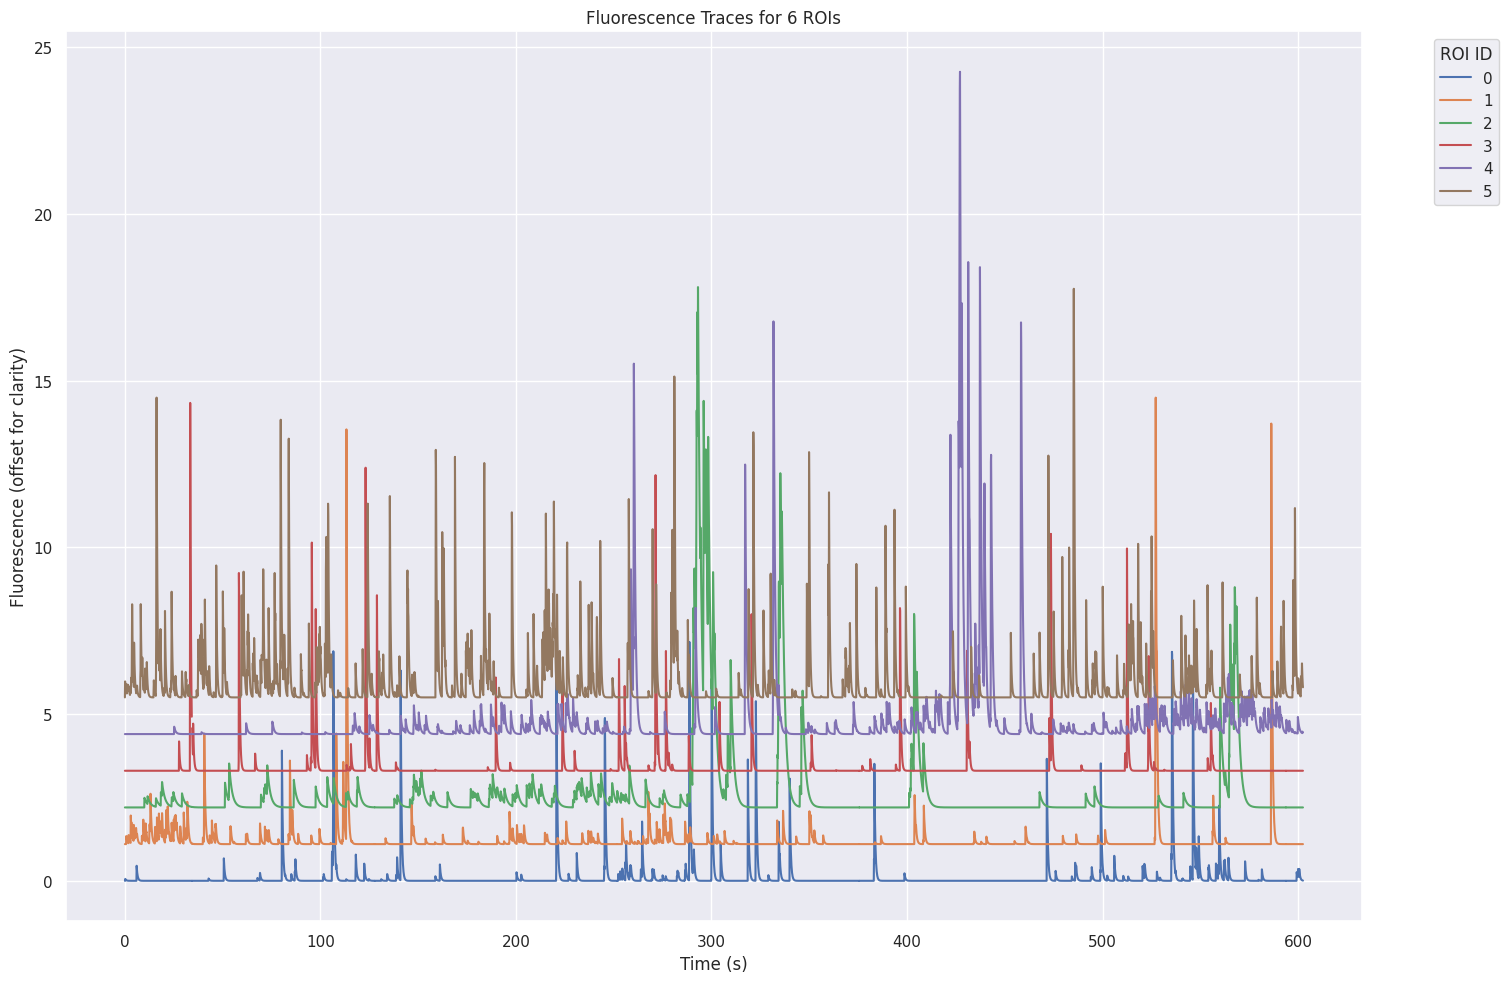

In [4]:
if nwbfile:
    try:
        # Apply seaborn theme for this plot
        sns.set_theme()

        # Access RoiResponseSeries data
        # Path based on the nwb-file-info output: nwb.processing["ophys"]["Fluorescence"]["RoiResponseSeries"]
        roi_response_series = nwbfile.processing['ophys']['Fluorescence']['RoiResponseSeries']
        fluorescence_data = roi_response_series.data[:]  # Shape: (time, num_rois)
        
        # Create timestamps
        # Timestamps can be generated from the rate. Alternatively, if roi_response_series.timestamps is available, use that.
        if hasattr(roi_response_series, 'timestamps') and roi_response_series.timestamps is not None:
            timestamps = roi_response_series.timestamps[:]
        else:
            timestamps = np.arange(fluorescence_data.shape[0]) / roi_response_series.rate

        # Get ROI IDs for labeling, if available
        try:
            # Path based on nwb-file-info: nwb.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"]
            roi_ids = nwbfile.processing['ophys']['ImageSegmentation']['PlaneSegmentation'].id[:]
        except Exception:
            roi_ids = [f"ROI {i}" for i in range(fluorescence_data.shape[1])]

        # Plot fluorescence traces
        plt.figure(figsize=(18, 10))
        
        offset_scale = 0
        if fluorescence_data.shape[1] > 1: # only add offset if more than one ROI
            # Calculate a robust offset: 75th percentile of peak-to-peak values of non-flat traces
            valid_trace_peaks = [np.max(fluorescence_data[:, i]) - np.min(fluorescence_data[:,i]) for i in range(fluorescence_data.shape[1]) if (np.max(fluorescence_data[:, i]) - np.min(fluorescence_data[:,i])) > 1e-6]
            if valid_trace_peaks:
                offset_scale = np.percentile(valid_trace_peaks, 75) 
            if offset_scale == 0: # fallback if all traces are flat or nearly flat
                offset_scale = 1.0 # A default arbitrary offset

        for i in range(fluorescence_data.shape[1]):
            trace_to_plot = fluorescence_data[:, i]
            offset = i * offset_scale * 1.1 # Add a bit more spacing
            plt.plot(timestamps, trace_to_plot + offset, label=str(roi_ids[i]))

        plt.xlabel('Time (s)')
        plt.ylabel('Fluorescence (offset for clarity)')
        plt.title(f'Fluorescence Traces for {fluorescence_data.shape[1]} ROIs')
        
        if fluorescence_data.shape[1] <= 10: # Only show legend if not too many ROIs
            plt.legend(title="ROI ID", bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend if shown
        plt.show()

    except KeyError as e:
        print(f"Could not find expected data for fluorescence traces: {e}")
        print("Available keys in nwbfile.processing['ophys'].data_interfaces:")
        if 'ophys' in nwbfile.processing:
            print(list(nwbfile.processing['ophys'].data_interfaces.keys()))
    except Exception as e:
        print(f"An error occurred while plotting fluorescence traces: {e}")
else:
    print("NWB file not loaded, skipping fluorescence traces plot.")

**Interpreting the Fluorescence Traces Plot:**
This plot displays the activity of multiple neurons (ROIs) simultaneously. Each trace is offset vertically for clarity.
- **Activity:** Sharp upward deflections typically represent calcium transients, indicative of neural activity.
- **Variability:** Note the differences in activity levels and patterns across ROIs. Some may be more active than others.
- **Y-axis Scaling:** If some ROIs have significantly larger fluorescence changes than others, the y-axis scaling might visually compress the traces of less active ROIs. For detailed analysis of specific ROIs, plotting them individually or in smaller groups with adjusted y-axes might be beneficial.

## Visualizing ROI Image Masks

The `PlaneSegmentation` table in an NWB file stores the spatial footprints (image masks) of the detected ROIs. We can visualize these masks to see the location and shape of the ROIs in the imaging field of view. Below, we plot a superposition of all ROI masks.

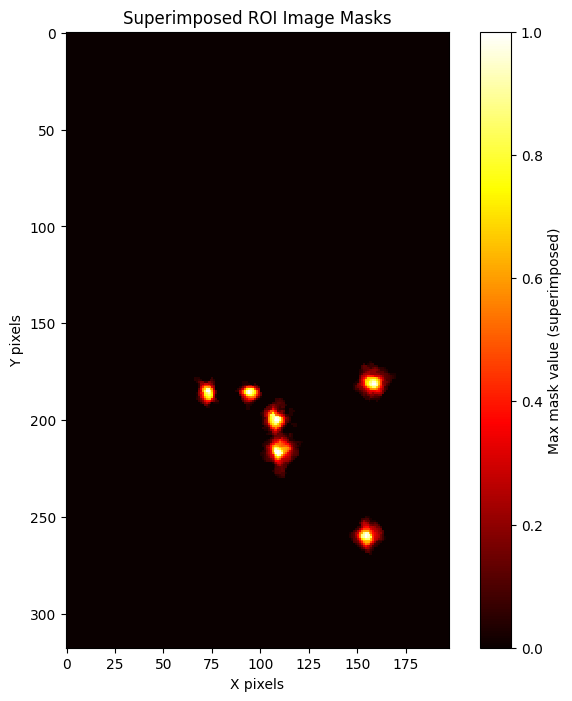

In [5]:
if nwbfile:
    try:
        # Access ImageSegmentation data
        # Path based on nwb-file-info: nwb.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"]
        plane_segmentation = nwbfile.processing['ophys']['ImageSegmentation']['PlaneSegmentation']
        
        # image_mask can be a 3D array (num_rois, height, width) or a list of 2D arrays / HDF5 dataset view
        image_masks_data = plane_segmentation['image_mask']

        if image_masks_data is None or image_masks_data.shape[0] == 0:
             print("No image masks found or image_mask data is empty.")
        else:
            # If it's a direct HDF5 dataset, we might need to read it into memory.
            # For image_mask, if it's a VectorData of 2D arrays, it typically gets loaded as a list of arrays or a 3D array by pynwb.
            # The exploratory script handled cases, let's simplify for the notebook assuming it's a 3D array or list of 2D arrays.
            
            if isinstance(image_masks_data, pynwb.base.VectorData): # typical for image_mask
                 masks_list = [m for m in image_masks_data] # Iterate to get actual masks
            elif isinstance(image_masks_data, h5py.Dataset):
                 masks_list = image_masks_data[:] # Load all if it's a simple HDF5 dataset
            else: # Should ideally be a 3D numpy array if loaded by pynwb already
                 masks_list = image_masks_data

            if not masks_list or not any(m.ndim == 2 and m.size > 0 for m in masks_list):
                 print("Image masks are not in the expected format (list of 2D arrays or 3D array).")
            else:
                # Determine the shape for the composite mask
                # Assuming all masks, once valid, have compatible shapes or we use the first mask's shape
                # For simplicity, assuming they are all same shape (common if from same ImagingPlane)
                # If masks_list is a 3D numpy array:
                if isinstance(masks_list, np.ndarray) and masks_list.ndim == 3:
                    composite_mask = np.max(masks_list, axis=0)
                # If masks_list is a list of 2D numpy arrays:
                elif isinstance(masks_list, list) and all(isinstance(m, np.ndarray) and m.ndim == 2 for m in masks_list if m is not None):
                    # Filter out None or empty masks if any
                    valid_masks = [m for m in masks_list if m is not None and m.size > 0]
                    if not valid_masks:
                        print("No valid 2D masks found after filtering.")
                        composite_mask = None
                    else:
                        # Stack them and take max, assuming they are same shape
                        try:
                            stacked_masks = np.stack(valid_masks, axis=0)
                            composite_mask = np.max(stacked_masks, axis=0)
                        except ValueError as ve:
                            print(f"Could not stack masks, likely due to shape mismatch: {ve}")
                            print("Attempting to create composite from masks of varying shapes by padding (using first valid mask's shape as reference for demo or max dimensions).")
                            # This part can get complex if shapes truly vary wildly and need robust padding.
                            # For notebook simplicity, we'll assume they are mostly compatible or show first.
                            # Let's find max dimensions if they truly vary
                            max_h = 0
                            max_w = 0
                            for m in valid_masks:
                                if m.shape[0] > max_h: max_h = m.shape[0]
                                if m.shape[1] > max_w: max_w = m.shape[1]
                            
                            temp_composite = np.zeros((max_h, max_w))
                            for m_idx, m in enumerate(valid_masks):
                                temp_composite[:m.shape[0], :m.shape[1]] = np.maximum(temp_composite[:m.shape[0], :m.shape[1]], m)
                            composite_mask = temp_composite

                else:
                    print(f"Image masks are in an unexpected format. Type: {type(masks_list)}")
                    composite_mask = None

                if composite_mask is not None and composite_mask.any():
                    plt.figure(figsize=(8, 8))
                    # Do not use seaborn styling for imshow
                    plt.style.use('default') # Reset to matplotlib default for this plot
                    plt.imshow(composite_mask, cmap='hot', interpolation='nearest')
                    plt.colorbar(label='Max mask value (superimposed)')
                    plt.title('Superimposed ROI Image Masks')
                    plt.xlabel('X pixels')
                    plt.ylabel('Y pixels')
                    plt.show()
                    sns.set_theme() # Re-apply seaborn theme if other plots follow
                elif composite_mask is not None:
                    print("Composite mask is all zeros, no ROIs to display or masks are empty.")
                else:
                    # Error message already printed
                    pass

    except KeyError as e:
        print(f"Could not find expected data for ROI masks: {e}")
        print("Available keys in nwbfile.processing['ophys'].data_interfaces:")
        if 'ophys' in nwbfile.processing:
            print(list(nwbfile.processing['ophys'].data_interfaces.keys()))
            if 'ImageSegmentation' in nwbfile.processing['ophys'].data_interfaces:
                 print("Keys in PlaneSegmentation:")
                 print(list(nwbfile.processing['ophys']['ImageSegmentation']['PlaneSegmentation'].colnames))


    except Exception as e:
        print(f"An error occurred while plotting ROI masks: {e}")

else:
    print("NWB file not loaded, skipping ROI masks plot.")

**Interpreting the ROI Masks Plot:**
This plot shows the spatial layout of the detected ROIs.
- **Brightness:** Brighter areas in the 'hot' colormap indicate pixels that are part of one or more ROI masks. The value represents the maximum mask value if ROIs overlap (values are typically 0 to 1).
- **Distribution:** This helps understand how cells are distributed across the imaged area. You might see clusters of cells or more sparse distributions.
- **Overlap:** Where ROIs overlap, the plot will show the maximum intensity of the overlapping masks.

## Summary and Future Directions

This notebook demonstrated how to:
1. Connect to the DANDI archive and list Dandiset assets.
2. Load a specific NWB file using its remote URL.
3. Inspect basic metadata of the NWB file.
4. Visualize fluorescence traces to observe neural activity.
5. Visualize ROI image masks to see their spatial footprints.

**Possible Future Directions for Analysis:**
*   **Detailed Event Analysis:** Investigate the properties of calcium transients (amplitude, duration, frequency) for individual ROIs or populations.
*   **Correlations:** Analyze correlations in activity between pairs or groups of ROIs.
*   **Behavioral Context:** If the Dandiset includes behavioral data (e.g., task performance, movement kinematics), correlate neural activity with behavioral events. (Note: This specific NWB file's session description is "Calcium imaging in SMA during the spontaneous condition", suggesting no specific task in this session).
*   **Population Dynamics:** Explore population-level activity patterns using techniques like Principal Component Analysis (PCA) or other dimensionality reduction methods.
*   **Comparison Across Sessions/Subjects:** If multiple NWB files are available for different sessions or subjects, perform comparative analyses.

Remember to consult the Dandiset documentation and any associated publications for more context on the experimental design and data.

In [6]:
# Close the NWB file IO if it was opened
if 'io' in locals() and io is not None:
    try:
        io.close()
        print("\nNWB file IO closed.")
    except Exception as e:
        print(f"Error closing NWB file IO: {e}")

if 'h5_file' in locals() and h5_file is not None:
    try:
        h5_file.close() # remfile should handle the underlying remote file object
        print("HDF5 file object closed.")
    except Exception as e:
        print(f"Error closing HDF5 file object: {e}")


NWB file IO closed.
HDF5 file object closed.


End of notebook.